## Open domain question answering system on SberQuAD dataset

**Основные задачи:**  
1. Построить открытую вопросно-ответную систему.  
2. Оценить результаты работы на примере датасета SberQuAD, сравнить с результатами закрытой вопросно-ответной системы.  
   
В качестве метрик будут использованы F1 и EM.  
В качестве датасета будет использована валидационная выборка SberQuAD.

**План:**  
1. Оценить метрики качества закрытой вопросно-ответной системы, когда модели предлагается найти ответ в единственном "родном" для неё контексте. Будем использовать эти метрики в качестве эталонных, чтобы оценить, насколько они снижаются при переходе в открытый тип, когда у модели вместо одного заданного контекста есть некоторое их множество.   
Модель для поиска ответа в контексте (`Reader`) построена нами ранее на обучающей выборке SberQuAD. Будем использовать сохранённые веса этой модели.  
2. Построить модель `Retriever`, выбирающую из всего множества контекстов `n` наиболее подходящих. В качестве меры похожести используется косинусная мера близости векторов. Для преобразования вопросов и контекстов в вектора для определения похожести используется tf-idf подход. Основа модели - разработка команды DeepPavlov, позволяющая создавать tf-idf вектора для контекстов и вопросов (http://docs.deeppavlov.ai/en/0.17.2/apiref/models/vectorizers.html).  
Наша задача здесь - дополнить её возможностью выбирать наиболее подходящие констексты в смысле выбранного критерия оптимальности.   
3. Найти итоговый ответ для каждого вопроса с помощью модели `Reader`. Для этого:  
- для каждого из выбранных контекстов предсказать начало и конец ответа;  
- выбрать наиболее правдоподобный контекст. Критерий - наибольшая совместная вероятность того, что выбранные начало и конец ответа являются верными. При необходимости скорректировать критерий дополнительными весами;
- сформировать итоговый текстовый ответ.  
4. Оценить критерии качества совместной работы `Retriever` и `Reader`. Оценить снижение метрик в сравнении с результатами п.1.

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "6, 7"
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from deeppavlov.models.tokenizers.ru_tokenizer import RussianTokenizer
from itertools import repeat
from scipy.special import softmax
from transformers import logging, AutoTokenizer, AutoModel
logging.set_verbosity_error()

import util
from models import Retriever, RUBertForQA

### 1. Оценка качества закрытой вопросно-ответной системы

Веса для модели `Reader` уже подготовлены. Загрузим их. Отметим, что используемый датасет (валидационная часть SberQuAD) не использовалась для обучения `Reader`, поэтому смело можем проверить на ней работу модели.

In [3]:
BATCH_SIZE = 2**8
DROPOUT = 0.5
model_name = "DeepPavlov/rubert-base-cased"
max_length = 512
tokenizer = AutoTokenizer.from_pretrained(model_name)
path_to_dict = '../model checkpoints/QA_best.pt'
bert = AutoModel.from_pretrained(model_name, num_hidden_layers = 9)
reader = RUBertForQA(bert, DROPOUT)
reader = torch.nn.DataParallel(reader, device_ids=[0, 1]).cuda()
reader.load_state_dict(torch.load(path_to_dict))

/home/naanvorobeva/miniconda3/envs/python3.7/lib/python3.7/site-packages/cryptography/hazmat/backends/openssl/x509.py:17: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  utils.DeprecatedIn35,


<All keys matched successfully>

Читаем файл с выборкой, готовим словари с контекстами (далее - документами), вопросами и ответами. `native_question_context` - словарь, содержащий для каждого id вопроса id "родного" документа.

In [23]:
context, question, answer, question_context = util.read_squad('data/dev-v1.1.json')
query_id = list(question.keys())
query_text = list(question.values())
native_doc_id = list(question_context.values())
native_doc_text = [context[v] for v in native_doc_id]
print('Number of questions:', len(question))
print('Number of documents:', len(context))

Number of questions: 5036
Number of documents: 3951


Количество документов меньше количества вопросов, т.к. в SberQuAD для одного документа предусмотрено несколько вопросов.  
Получим метрики.

In [6]:
# get encodings and create data loader object
encoding_init = (tokenizer(native_doc_text, query_text,
                             truncation=True, padding=True, max_length = max_length, return_tensors = 'pt'))
dataset_init = util.SquadDataset(encoding_init)
loader_init = DataLoader(dataset_init, batch_size=BATCH_SIZE, shuffle=False)

# get predictions (logits), construct text predicted answers and evaluate quality
logp_start_init, logp_end_init, _ = util.get_logits(reader, loader_init, get_loss=False)
pred_answer_init, _ = util.get_answer(logp_start_init, logp_end_init, 
    native_doc_text, native_doc_id, query_id, encoding_init)
metrics_init = util.eval_dicts(answer, pred_answer_init, False)
print(metrics_init)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:28<00:00,  1.45s/it]


{'F1': 82.32498149206079, 'EM': 63.185067513899924}


Запомним: F1 = 82%, EM = 63%

### 2. Модель `Retriever`

Подготовим данные

In [7]:
doc = list(context.values())
doc_id = list(context.keys())
doc_num = list(range(len(doc)))
save_path = 'tf_idf_sberquad_dev.npz'
load_path = 'tf_idf_sberquad_dev.npz'
hash_size = 2**24
tokenizer_tf_idf = RussianTokenizer(lemmas = True, ngram_range = (1, 2))

Следующая ячейка нужна для единовременной загрузки в модель документов, формирования из них tf-idf матрицы и сохранения её локально по пути в переменной `save_path`. Если матрица уже создана, выполнение ячейки можно пропустить.

In [7]:
retriever_init = Retriever(tokenizer = tokenizer_tf_idf, hash_size = hash_size, save_path = save_path, 
                                load_path = load_path, **{"mode": 'train'})
retriever_init.fit(docs = doc, doc_ids = doc_id, doc_nums = doc_num)
retriever_init.save()

2022-04-28 16:00:08.343 INFO in 'deeppavlov.models.vectorizers.hashing_tfidf_vectorizer'['hashing_tfidf_vectorizer'] at line 153: Tokenizing batch...
2022-04-28 16:01:35.565 INFO in 'deeppavlov.models.vectorizers.hashing_tfidf_vectorizer'['hashing_tfidf_vectorizer'] at line 155: Counting hash...
2022-04-28 16:01:36.35 INFO in 'deeppavlov.models.vectorizers.hashing_tfidf_vectorizer'['hashing_tfidf_vectorizer'] at line 214: Saving tfidf matrix to /home/naanvorobeva/lab/QA/tf_idf_sberquad_dev.npz


Создадим объект модели, загрузим в неё вопросы и получим id наиболее релевантных документов - `retrieved_doc_id`.  
Выберем по `n = 3` документа для каждого вопроса.  
`total_doc_similarity` - вспомогательная матрица, содержащая для каждого вопроса (в столбцах) значения меры схожести для каждого документа (в строках).  
Из неё получим `retrieved_doc_similarity` - матрицу, в которой для каждого вопроса (в строках) содержатся значения похожести только для выбранных документов (в столбцах). Размерность матрицы [количество вопросов, количество выбранных документов для вопроса]

In [8]:
retriever = Retriever(tokenizer = tokenizer_tf_idf, hash_size = hash_size, 
                                       save_path = save_path, load_path = load_path, **{"mode": 'infer'})
n = 3
retrieved_doc_id, total_doc_similarity = retriever.retrieve(query_text, n)
retrieved_doc_similarity = np.partition(total_doc_similarity, -n, axis=0)[-n:].T
retrieved_doc_text = [context[k] for k in retrieved_doc_id]

2022-05-04 15:51:34.407 INFO in 'deeppavlov.models.vectorizers.hashing_tfidf_vectorizer'['hashing_tfidf_vectorizer'] at line 264: Loading tfidf matrix from /home/naanvorobeva/lab/QA/tf_idf_sberquad_dev.npz
2022-05-04 15:51:48.415 INFO in 'deeppavlov.models.vectorizers.hashing_tfidf_vectorizer'['hashing_tfidf_vectorizer'] at line 264: Loading tfidf matrix from /home/naanvorobeva/lab/QA/tf_idf_sberquad_dev.npz


Интересным на наш взгляд будет оценить точность модели (показатель `accuracy`). Принцип расчёта простой. Для каждого вопроса проверяется, входит ли "родной" для него документ в список документов, выбранных моделью. Число вопросов с правильно выбранным документом делится на общее число вопросов.  
Построим зависимость показателя `accuracy` от количества выбранных документов для каждого вопроса.

Text(0.5, 1.0, 'Retriever accuracy')

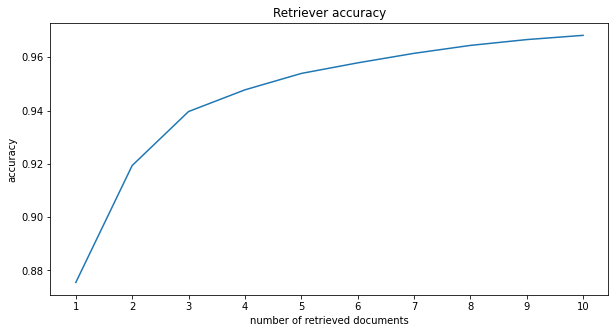

In [9]:
retriever_acc = []
num_retrieved_doc = 10
for i in range(1, num_retrieved_doc + 1):
    retriever_acc.append(
        util.retriever_accuracy(total_doc_similarity, query_id, doc_id, question_context, i))
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

ax.plot(range(1, num_retrieved_doc + 1), retriever_acc)
ax.set_xlabel('number of retrieved documents')
ax.set_xticks(range(1, num_retrieved_doc + 1))
ax.set_ylabel('accuracy')
ax.set_title('Retriever accuracy')

Достаточно хорошие результаты уже для `n = 3` документов: в 94% случаев модель в список релевантных документов включает "родной" для вопроса документ. Остановимся на `n = 3`.

### Предсказание ответов. Модель `Reader`

Наконец, загрузим в модель `Reader` вопросы и выбранные релевантные документы. Для каждого вопроса выберем наиболее правдоподобный ответ в смысле выбранного критерия: максимальная совместная вероятность того, что предсказанные начало и конец ответа являются верными.  
Аналогично посмотрим на точность модели `Reader`: как часто модель извлекает итоговый ответ из "родного" для вопроса документа.

In [11]:
# expand queries to satisfy dimension.
# Query list has lenght [number of queries],
# but doc list lenght is [number of queries * n], n is number of docs retrieved for each query.
# so we need to duplicate each query n times
retrieved_query_text = [x for item in query_text for x in repeat(item, n)]

# get encodings and create data loader object
encoding = (tokenizer(retrieved_doc_text, retrieved_query_text,
                             truncation=True, padding=True, max_length = max_length, return_tensors = 'pt'))
dataset = util.SquadDataset(encoding)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

# get predictions (logits), construct text predicted answers and evaluate quality
logp_start, logp_end, _ = util.get_logits(reader, loader, get_loss=False)
pred_answer, pred_doc_id = util.get_answer(logp_start, logp_end, 
    retrieved_doc_text, retrieved_doc_id, query_id, encoding)
metrics = util.eval_dicts(answer, pred_answer, False)
print(metrics)
acc = np.sum(pred_doc_id==native_doc_id) / len(native_doc_id)
print('Reader accuracy:', acc)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [01:26<00:00,  1.45s/it]


{'F1': 62.19189094812787, 'EM': 48.35186656076251}
Reader accuracy: 0.6888403494837172


Видим две неприятные вещи:  
    1. Метрики качества существенно снизились: F1/EM = 62/48 против 82/63 для закрытой вопросно-ответной системы.  
    2. Модель выбирает верный документ только в 69% случаев. То есть если в список релевантных документов, выбранных `Retriever`, попал правильный документ, модель `Reader` может извлечь ответ из другого документа.  
Пока не анализируя причины такого поведения, постараемся улучшить работу модели `Reader`.  
  
  
Идея проста. Если точность `Retriever` достаточно высокая, добавим в `Reader` в критерий выбора документа для поиска ответа дополнительные веса. Они будут пропорциональны мере схожести документа и вопроса, по которой `Retriever` выбирает релевантные документы. Тогда документы, в которых более уверен `Retriever`, получат больший вес и с большей верояностью будут выбраны моделью `Reader`.  

У нас есть данные о схожести каждого вопроса с каждым выбранным для него документом, хранящиеся в переменной `retrieved_doc_similarity`. Логично применить фунцию `softmax`, чтобы трансформировать эти значения в веса, в сумме равные единице.  
Но здесь нужно отметить следущее. В качестве меры похожести мы используем косинусную меру близости, т.е. небольшие по величине значения. Это видно на распределении ниже.

Text(0.5, 1.0, 'Similarity measure distribution')

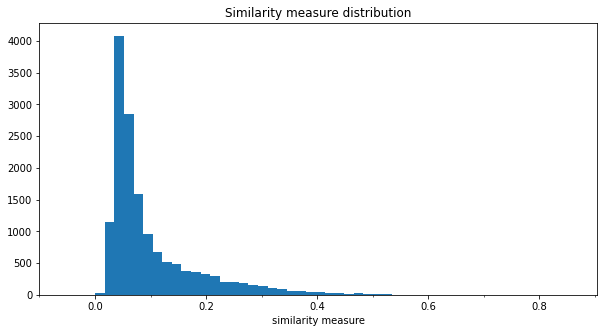

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
ax.hist(retrieved_doc_similarity.flatten(), bins = 50, density = False)
ax.set_xticks([p/10 for p in range(-1, 10, 1)], minor = True)
ax.set_xlabel('similarity measure')
ax.set_title('Similarity measure distribution')

Если применять `softmax` без корректирующих коэффициентов, мы получим равновероятный выбор.  
Пример:

In [13]:
k = 0
print('similarity measure:', np.round(retrieved_doc_similarity[k], 3))
print('weights after softmax:', np.round(softmax(retrieved_doc_similarity[k]), 3))

similarity measure: [0.048 0.066 0.122]
weights after softmax: [0.323 0.329 0.348]


Несмотря на то, что мера близости для разных документов отличается в разы (0.5 против 0.12), веса существенно не отличаются. Такой подход нам не поможет. Поэтому добавим т.н. "температуру", чтобы сделать выбор не таким равновероятным.  
Заново получим ответы для тех же данных, но с учётом весов.

In [14]:
T = 0.01
weights = softmax(retrieved_doc_similarity / T, axis=1)

# here we don't need to create encodings, data loader and get logits.
# we can use existing predictions. 
# All we need to do is to add weights to get_answer function

# construct text predicted answers and evaluate quality
pred_answer_weighted, pred_doc_id_weighted = util.get_answer(logp_start, logp_end, 
    retrieved_doc_text, retrieved_doc_id, query_id, encoding, weights)
metrics_weighted = util.eval_dicts(answer, pred_answer_weighted, False)
print(metrics_weighted)
acc_weighted = np.sum(pred_doc_id_weighted==native_doc_id) / len(native_doc_id)
print('Reader accuracy with weights:', acc_weighted)

{'F1': 75.09735259117319, 'EM': 57.60524225575854}
Reader accuracy with weights: 0.8884034948371724


### 4. Оценка результатов. Выводы

Соберём метрики качества для рассмотренных случаев вместе.

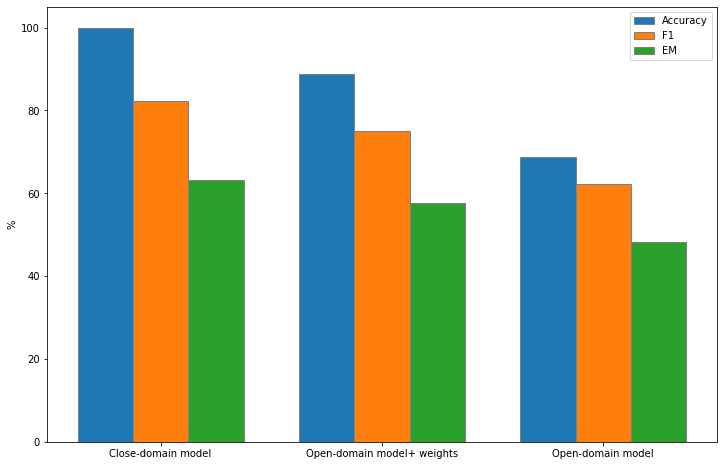

In [17]:
# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))
 
# set height of bar
accuracy = [100, acc_weighted * 100, acc * 100]
F1 = [metrics_init['F1'], metrics_weighted['F1'], metrics['F1']]
EM = [metrics_init['EM'], metrics_weighted['EM'], metrics['EM']]
 
# Set position of bar on X axis
br1 = np.arange(len(F1))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
 
# Make the plot
plt.bar(br1, accuracy, width = barWidth, edgecolor ='grey', label ='Accuracy')
plt.bar(br2, F1, width = barWidth, edgecolor ='grey', label ='F1')
plt.bar(br3, EM, width = barWidth, edgecolor ='grey', label ='EM')
 
# Adding Xticks
#plt.xlabel('Model')
plt.ylabel('%')
plt.xticks([r + barWidth for r in range(len(F1))],
        ['Close-domain model', 'Open-domain model+ weights', 'Open-domain model'])
 
plt.legend()
plt.show()

Рассмотрели 3 модели:  
    - закрытую вопросно-ответную систему;  
    - открытую вопросно-ответную систему;  
    - открытую вопросно-ответную систему, для которой уверенность модели `Reader` в правильности ответа корректируется весами, учитывающими уверенность модели `Retriever` в выборе релевантного документа.  
По понятным причинам лучшие метрики качества показала закрытая модель: F1/EM = 82/63.  
Необходимость выбора верного документа для поиска ответа добавляет дополнительную ошибку в работу, и лучшие показатели, которых удалось добиться: F1/EM = 75/58. Такой результат получен с учётом дополнительных весов, "подталкивающих" модель `Reader` выбирать правильный документ для поиска ответа. Без весов результаты невёселые: F1/EM = 62/48. Результаты обеих моделей получены, если для каждого вопроса выбирать по 3 наиболее релевантных документа.  
  
Интересными на наш взгляд результатами стали:  
1. Высокая точность модели `Retriever`: порядка 90% уже для двух выбранных документов на вопрос. При этом для модели использовался простой tf-idf подход. Возможно, это связано с датасетом SberQuAD, построенным на статьях Википедии. Во многих вопросах и документах встречается специфическая лексика, совпадение которой в вопросе и документе приводит к появлению значимой меры близости, позволяющей выбрать правильный документ.  
Интересным бдет проверить работу подхода на предметной области, в которой объём лексики не так велик, и отбор релевантных документов может стать не такой простой задачей.  
2. Невысокая точность модели `Reader` по выбору документа без учёта весов. Несмотря на то, что в 94% случаев `Retriever` передаёт `Reader` правильный документ, модель в некоторых случаях извлекает ответ из неверного документа. Итоговая точность выбора правильного ответа такой модели 69%. Возможно, это связано с тем, что `Reader` обучался на закрытом типе вопросно-ответных систем, и его можно дообучить находить правильные документы из некоторого множества. Пока этот вопрос остаётся неясным. 

### Дополнительно

В качестве примера посмотрим на работу модели с весами на 5 случайных вопросах.

In [24]:
visual_ids = np.random.choice(list(pred_answer_weighted), size=5, replace=False)
for i, id_ in enumerate(visual_ids):
    pred_answer_text = pred_answer_weighted[id_]
    question_text = question[id_]
    context_id = question_context[id_]
    context_text = context[context_id]
    answer_text = answer[id_]['text']
    print('Пример ', i+1)
    print('Контекст:', context_text)
    print()
    print('Вопрос:', question_text)
    print('Предсказанный ответ:', pred_answer_text)
    print('Правильный ответ:', answer_text)
    print()

Пример  1
Контекст: На долю беспозвоночных приходится около 80 % всех известных видов животных, поэтому нет ничего удивительного в том, что они скрывают в себе огромное множество вирусов различных типов. Наиболее изучены вирусы, поражающие насекомых, но даже здесь доступная по ним информация носит фрагментарный характер. Впрочем, в последнее время были описаны вирусные заболевания и у других беспозвоночных. Эти вирусы остаются малоизученными, и некоторые сообщения об открытии следует принимать с осторожностью, пока вирусная природа этих болезней не будет окончательно доказана. Кроме того, необходимо также проверить инфективность изолированных вирусов по отношению к неинфицированным хозяевам того же вида, у кого эти вирусы были обнаружены.

Вопрос: Какие вирусные заболевания в последнее время были описаны?
Предсказанный ответ: у других беспозвоночных.
Правильный ответ: других беспозвоночных

Пример  2
Контекст: Есть попытки видеть начало публицистики в далёком прошлом литературы; Эрнест